In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_excel(r"C:/Users/arsinta/Downloads/data_clean_labeled.xlsx")

print("PREVIEW DATA")
display(data.head())
print("\nINFO DATA")
print(data.info())

PREVIEW DATA


,User_comment,tanggal_posting,comment_clean,label
0,yuliadi_kurniawan,29 juli 2025,Sang Maestro Thomas Alfa Fikri Sound wakakakak,positif
1,erwan12081979gmail.com4,29 juli 2025,Sounds fikri Edison mantap tetap semangat ya,positif
2,yoshefarie,19 Agustus 2025,Ereg apa lagi error kah saya gak bisa daftar,respon
3,tjapdl98_kotabatu,12 Agustus 2025,siap,respon
4,susiloariwardani,6 Juli 2025,Sukses untuk timja BPOM,positif



INFO DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User_comment     514 non-null    object
 1   tanggal_posting  514 non-null    object
 2   comment_clean    514 non-null    object
 3   label            514 non-null    object
dtypes: object(4)
memory usage: 16.2+ KB
None


In [2]:
bulan_map = {
    "Januari": "01", "Februari": "02", "Maret": "03", "April": "04",
    "Mei": "05", "Juni": "06", "Juli": "07", "Agustus": "08",
    "September": "09", "Oktober": "10", "November": "11", "Desember": "12"
}

# pastikan string bersih
data["tanggal_posting"] = data["tanggal_posting"].astype(str).str.strip()

# (opsional) kalau ada tahun kepanjangan (mis. 2023333) -> ambil 4 digit awal
data["tanggal_posting"] = data["tanggal_posting"].str.replace(r"(\d{4})\d+", r"\1", regex=True)

# deteksi format
mask_indonesia = (
    data["tanggal_posting"].str.contains(r"[A-Za-z]", regex=True, na=False) &
    ~data["tanggal_posting"].str.contains("-", regex=False, na=False)
)
mask_english = data["tanggal_posting"].str.contains("-", regex=False, na=False)

def parse_tanggal_indonesia(x: str):
    """
    Contoh input: '12 Oktober 2023'
    Output: '2023-10-12'
    """
    try:
        parts = x.split()
        if len(parts) != 3:
            return pd.NaT
        hari, bulan_text, tahun = parts
        bulan = bulan_map.get(bulan_text.capitalize(), None)
        if bulan is None:
            return pd.NaT
        return pd.to_datetime(f"{tahun}-{bulan}-{hari.zfill(2)}", errors="coerce")
    except:
        return pd.NaT

# kolom hasil final
data["tanggal_fixed"] = pd.NaT

# parse Indonesia
data.loc[mask_indonesia, "tanggal_fixed"] = data.loc[mask_indonesia, "tanggal_posting"].apply(parse_tanggal_indonesia)

# parse English (contoh: 12-Oct-23)
data.loc[mask_english, "tanggal_fixed"] = pd.to_datetime(
    data.loc[mask_english, "tanggal_posting"],
    format="%d-%b-%y",
    errors="coerce"
)

# final coercion
data["tanggal_fixed"] = pd.to_datetime(data["tanggal_fixed"], errors="coerce")

print("\nCEK HASIL PARSING (20 BARIS PERTAMA)")
display(data[["tanggal_posting", "tanggal_fixed"]].head(20))
print("Jumlah tanggal yang gagal parse (NaT):", data["tanggal_fixed"].isna().sum())



CEK HASIL PARSING (20 BARIS PERTAMA)


,tanggal_posting,tanggal_fixed
0,29 juli 2025,2025-07-29
1,29 juli 2025,2025-07-29
2,19 Agustus 2025,2025-08-19
3,12 Agustus 2025,2025-08-12
4,6 Juli 2025,2025-07-06
5,3 Juli 2025,2025-07-03
6,3 Juli 2025,2025-07-03
7,3 Juli 2025,2025-07-03
8,3 Juli 2025,2025-07-03
9,3 Juli 2025,2025-07-03


Jumlah tanggal yang gagal parse (NaT): 0


In [3]:
daily_counts = (
    data.dropna(subset=["tanggal_fixed"])
        .groupby("tanggal_fixed")
        .size()
        .reset_index(name="jumlah_komentar")
        .sort_values("tanggal_fixed")
)

print("\nPREVIEW AGREGASI HARIAN")
display(daily_counts.head())


PREVIEW AGREGASI HARIAN


,tanggal_fixed,jumlah_komentar
0,2024-01-04,1
1,2024-01-05,1
2,2024-01-19,1
3,2024-01-21,3
4,2024-01-31,4


C:\Users\arsinta\AppData\Local\Temp\ipykernel_20744\3562609541.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.countplot(x='label', data=data, palette='pastel')


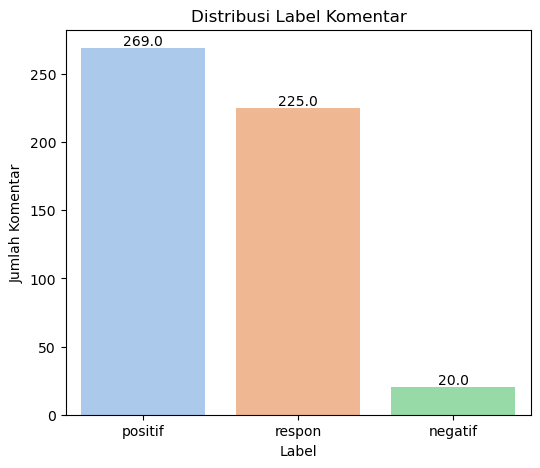

In [10]:
plt.figure(figsize=(6,5))
ax1 = sns.countplot(x='label', data=data, palette='pastel')
plt.title('Distribusi Label Komentar')
plt.xlabel('Label')
plt.ylabel('Jumlah Komentar')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', fontsize=10)
plt.show()


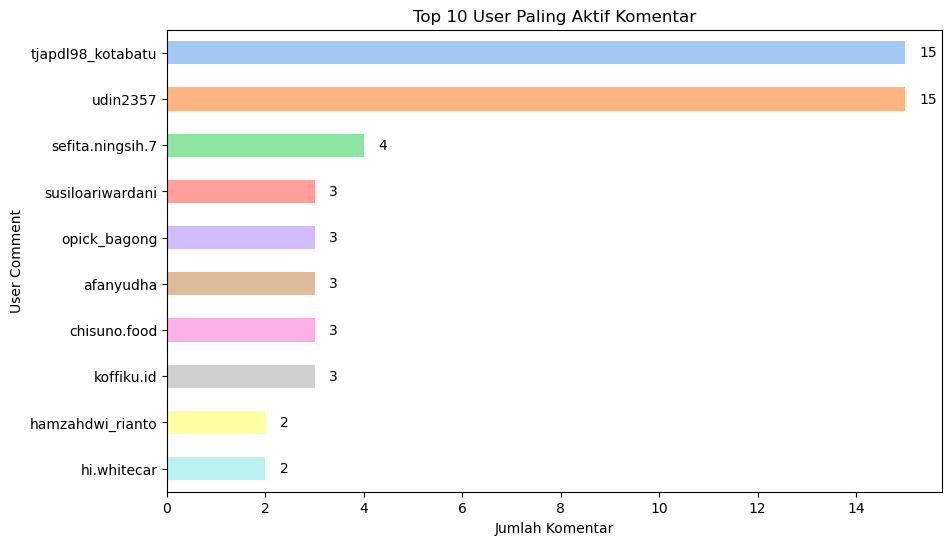

In [8]:
top_users = data['User_comment'].value_counts().head(10)
plt.figure(figsize=(10,6))
colors = sns.color_palette('pastel', n_colors=10)
ax2 = top_users.plot(kind='barh', color=colors)
plt.xlabel('Jumlah Komentar')
plt.ylabel('User Comment')
plt.title('Top 10 User Paling Aktif Komentar')
plt.gca().invert_yaxis()
for i, v in enumerate(top_users):
    ax2.text(v + 0.3, i, str(v), color='black', va='center', fontsize=10)
plt.show()


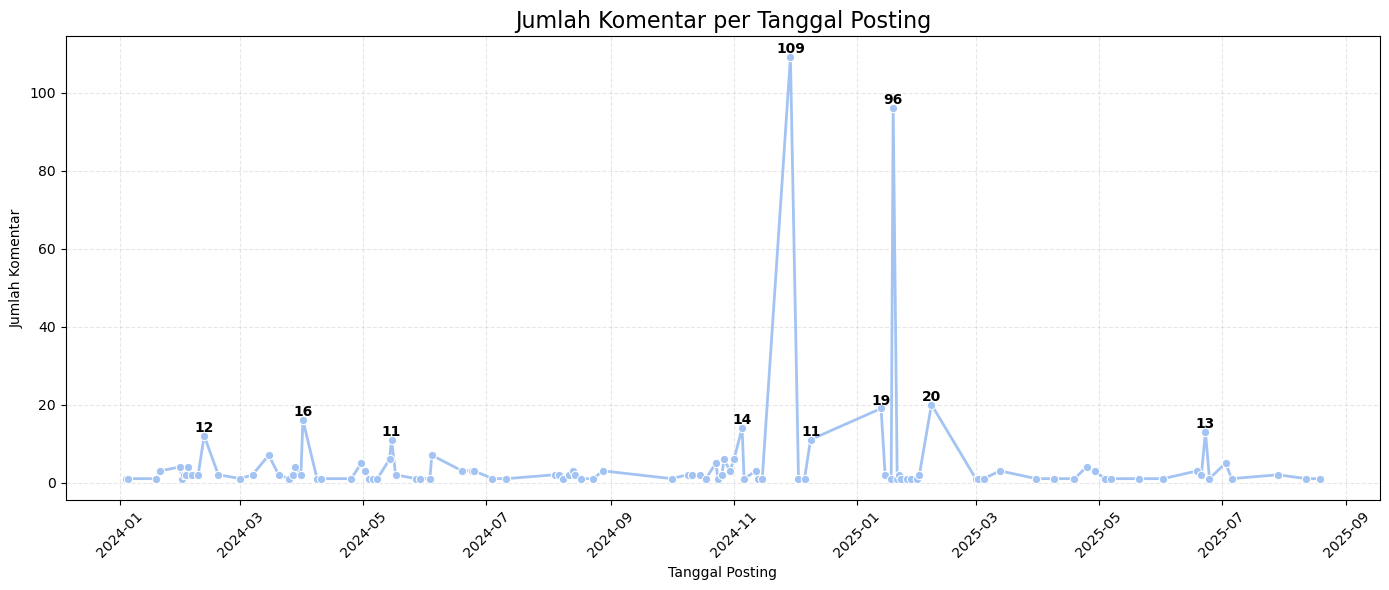

In [9]:
daily_counts = data.groupby('tanggal_fixed').size().reset_index(name='jumlah_komentar')
daily_counts = daily_counts.sort_values('tanggal_fixed')

plt.figure(figsize=(14,6))
sns.lineplot(
    data=daily_counts,
    x='tanggal_fixed', 
    y='jumlah_komentar',
    marker='o',
    linewidth=2,
    markersize=6,
    color='#a3c4f3'
)

for i in range(len(daily_counts)):
    y = daily_counts['jumlah_komentar'].iloc[i]
    x = daily_counts['tanggal_fixed'].iloc[i]

    if y >= 10:  # hanya tampilkan label jika komentar cukup banyak
        plt.text(
            x, y + 1,
            str(y),
            ha='center',
            fontsize=10,
            fontweight='bold'
        )

plt.title("Jumlah Komentar per Tanggal Posting", fontsize=16)
plt.xlabel("Tanggal Posting")
plt.ylabel("Jumlah Komentar")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
